In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

## Loading Dataset

In [75]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")


# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/7, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (22542, 36)


In [76]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_std_short.loc[Attack_label_short['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_std_short.loc[Attack_label_short['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

from sklearn.model_selection import train_test_split
X_train, array_test_0 = train_test_split(Dataset_only0, train_size=0.6, random_state=22)

Sample shape of only normal label (3408, 36)
Sample shape of only abnormal label (19134, 36)


* X_train is dataframe of only normal samples

In [77]:
# preparing the test dataset by joining some of the normal and abnormal samples.
import numpy as np

array1 = Dataset_only1.to_numpy() 

# Joining the abnormal and normal samples for testing
X_test = np.concatenate((array1, array_test_0), axis=0)
Y_test = np.concatenate((np.ones(array1.shape[0])*-1, np.ones(array_test_0.shape[0])), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (2044, 36)
Shape of X_test:  (20498, 36)


* X_test is array of both normal and abnormal samples with huge proportion of abnormal instances.<br>
Y_test is label of 1 and -1 for the normal and abnormal instances respectively.  


## Hyperparameter

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
parameters = {'kernel':('linear', 'rbf', 'poly'), 'nu':[0.1, 0.5, 0.9], 'degree':[2, 3, 5]}
clf = OneClassSVM()
grid_eval = GridSearchCV(clf, parameters, cv=3)

from sklearn.metrics import make_scorer, roc_auc_score, f1_score

def custom_scorer(y_true, y_pred):
    # OneClassSVM predicts -1 for anomalies and 1 for inliers
    y_pred = [1 if x == -1 else -1 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(custom_scorer, greater_is_better=True)

Y_train = np.ones(X_train.shape[0]) # all normal samples
grid_eval = GridSearchCV(clf, parameters, scoring=scorer, cv=2)
search_grid = grid_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

Hyperparameters:  {'degree': 5, 'kernel': 'poly', 'nu': 0.9}
Best score:  0.9528644553902488


Number of Samples analyse

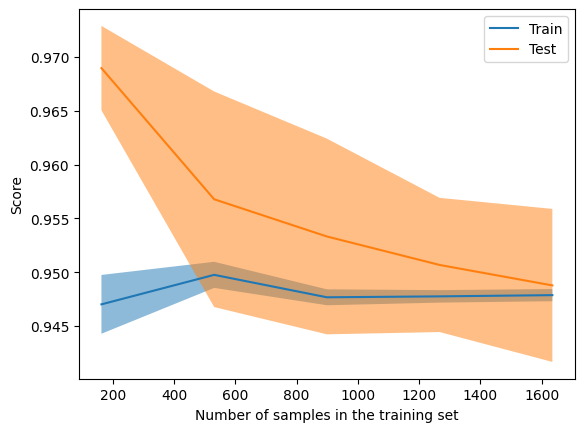

In [62]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
clf = OneClassSVM(kernel='poly', nu=0.9, degree=5)

from sklearn.metrics import make_scorer, f1_score
def custom_scorer(y_true, y_pred):
    # OneClassSVM predicts -1 for anomalies and 1 for inliers
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(custom_scorer, greater_is_better=True)
Y_train = np.ones(X_train.shape[0]) # all normal samples

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, Y_train, scoring=scorer, cv=5)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

* around 2000 samples to train would be optimal

## The Modal

In [72]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(kernel="poly", degree= 3, nu= 0.9, gamma= 'scale')
clf.fit(X_train)
Y_pred = clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


### Evaluation

In [67]:
from sklearn import metrics
print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

Average Accuracy Score: 0.9411162064591667
Balanced Accuracy Score: 0.5575513196480938
         Precision  Recall  F1-Score
Anomaly   0.940662     1.0  0.969424


* Average accuracy tells how many classified samples are right. Whereas balanced Accuracy takes Recall of each class into account. It is less because our normal samples are small proportion and 88% of them are misclassed.
* Precision should come to 0.53 but why 0.940662???

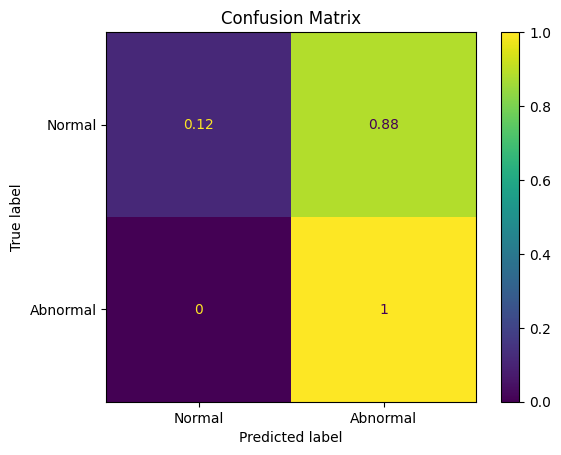

In [68]:
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

* High False Positive Rates that means too many Normal instances as abnormal recognized (Fp = 0.89).<br>
But the Modal identifies all abnormal instances (TP = 1). That means no abnormal samples gone unnoticed.

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Precision-Recall Curve')

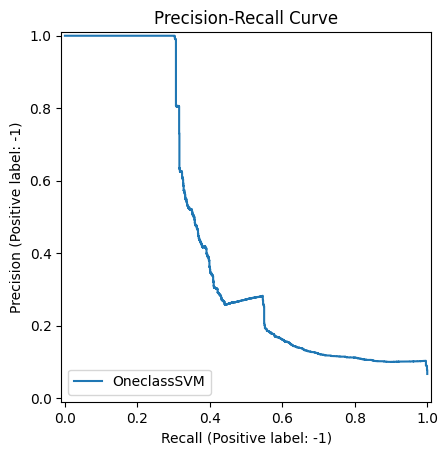

In [73]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
Y_scores = clf.decision_function(X_test)

prec, recall, thresh = precision_recall_curve(Y_test, Y_scores)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='OneclassSVM').plot()
plt.title('Precision-Recall Curve')

* The AU Curve suggests that while the model can confidently identify a small number of abnormal instances, it struggles to generalize well when trying to identify a larger number of them, leading to many false positives

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


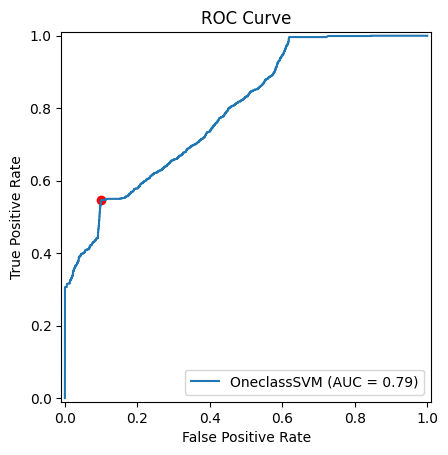

In [74]:
# For ROC-AUC, we need decision function scores (not just -1 or 1 labels)
Y_scores = clf.decision_function(X_test)

fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OneclassSVM')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()

* The Area under the curve indicates that there is a 79% chance that the model will rank a randomly chosen abnormal instance higher than a randomly chosen normal instance

## PCA

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
clf = OneClassSVM(kernel="poly", degree= 4, nu= 0.9, gamma= 'scale')
clf.fit(X_PCA)
Y_pred = clf.predict(X_test_PCA)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
parameters = {'kernel':('linear', 'rbf', 'poly'), 'nu':[0.1, 0.5, 0.9], 'degree':[2, 3, 4]}
clf = OneClassSVM()
grid_eval = GridSearchCV(clf, parameters, cv=3)

from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    # OneClassSVM predicts -1 for anomalies and 1 for inliers
    y_pred = [1 if x == -1 else -1 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(custom_scorer, greater_is_better=True)

Y_train = np.ones(X_PCA.shape[0]) # all normal samples
grid_eval = GridSearchCV(clf, parameters, scoring=scorer, cv=2)
search_grid = grid_eval.fit(X_PCA, Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

Hyperparameters:  {'degree': 4, 'kernel': 'poly', 'nu': 0.9}
Best score:  0.9496377914746784


### Evaluation

Average Accuracy Score: 0.9411162064591667
Balanced Accuracy Score: 0.5575513196480938
         Precision  Recall  F1-Score
Anomaly   0.940662     1.0  0.969424


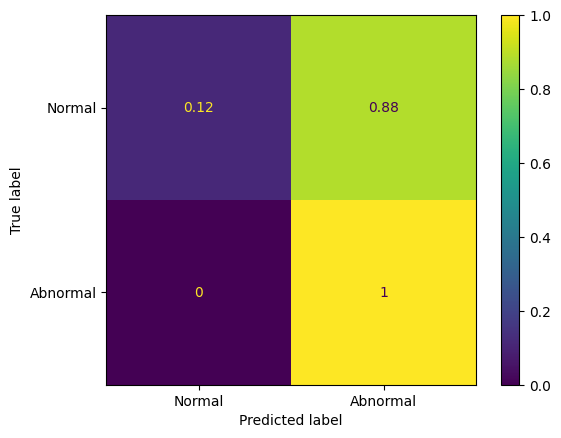

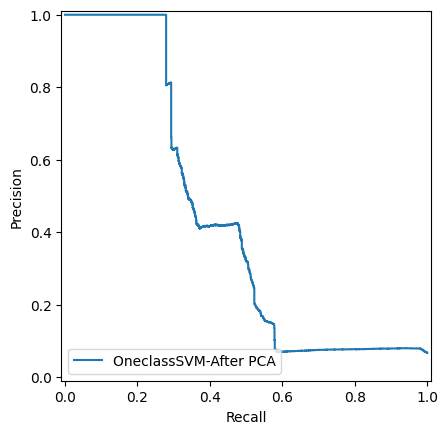

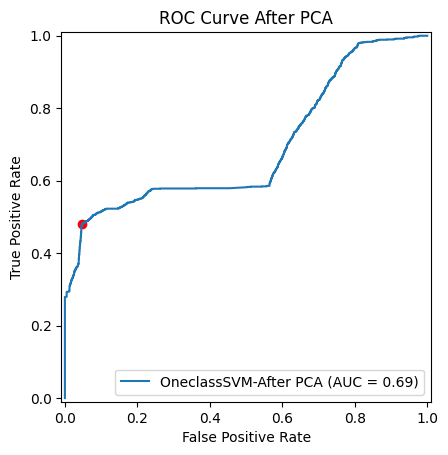

In [53]:
# Precision, Recall, F1-Score
from sklearn import metrics
print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.show()

# Precision Recall Curve
Y_scores = clf.decision_function(X_test_PCA) # decision function scores because we are using OneClassSVM

prec, recall, _ = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='OneclassSVM-After PCA').plot()

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OneclassSVM-After PCA')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.title("ROC Curve After PCA")
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.show()

## Conclusion

One class SVM which uses Gaussian kernel to learn a boundary around the Normal only train Datasamples and with the help of 'nu' Parameter the Modal can be set for strict or soft boundary. (nu = (0, 1] )<br>

The Oneclass SVM which is used for Novelty detecetion here produced an above average results in classifying the samples from normal to abnormal. But for detecting the anomalie (Recall for abnormal sample) the modal performs good and produced same result after the PCA dimension reduction.<br>

The ROC curve shows that for small FPR only half the maximum of TPR can be achieved. which means in order to detect all the anomalies (TPR = 1) the modal have to detect some Normal samples falsely (FPR is not low). 